<a href="https://colab.research.google.com/github/prvnsingh/PlantDiseaseRecongnition/blob/main/shufflenet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This dataset contains three labels: Healthy, Powdery, Rust referring to plant conditions. There is a total of 1530 images divided into train, test, and validation sets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import requirements
!pip install -q addict

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import os
import random
from addict import Dict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

In [ ]:
# Functions
def seed_everything(seed:int=42) -> None:
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def get_optimizer(model:torch.nn.Module, name:str="SGD", parameters:dict={}) -> torch.optim.Optimizer:
    optimizers = {
        "SGD": torch.optim.SGD,
        "AdamW": torch.optim.AdamW,
        "Adam": torch.optim.Adam,
        "RMSprop": torch.optim.RMSprop,
    }
    
    instance = optimizers.get(name, "SGD")     
    optimizer = instance(model.parameters(), **parameters)
    
    return optimizer


def get_scheduler(optimizer:torch.optim.Optimizer, name:str, parameters:dict):
    schedulers = {
        "ReduceLROnPlateau": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "LambdaLR": torch.optim.lr_scheduler.LambdaLR,
        "StepLR": torch.optim.lr_scheduler.StepLR,
        "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR,
        "MultiplicativeLR": torch.optim.lr_scheduler.MultiplicativeLR,
        "MultiStepLR": torch.optim.lr_scheduler.MultiStepLR,
    }
    
    instance = schedulers[name]     
    scheduler = instance(optimizer, **parameters)
    
    return scheduler



def accuracy_score(predictions:torch.Tensor, targets:torch.Tensor) -> torch.Tensor:
    amount = (predictions == targets).sum()
    accuracy = amount / targets.size(0)
    
    return accuracy



def hide_spines(ax, spines=["top", "right", "left", "bottom"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)
        
def plot_images(rows, cols, indexes, class_=0):
    min_index = min(indexes)
    max_index = max(indexes)
    fig = plt.figure(figsize=(3*cols, 3*rows))
    for i in range(*indexes):
        item = train_dataset[i]
        image = item.image
        label = item.label

        if label == class_:
            ax = fig.add_subplot(rows, cols, (i - min_index)+1)
            ax.imshow(image.permute(1, 2, 0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

    fig.text(s=f"{train_dataset.labels[class_]} leaves", x=0.125, y=0.9, fontweight="bold", fontfamily="serif", fontsize=20)
    fig.show()
    
    
def get_logger(name:str=__name__, format:str="[%(asctime)s][%(levelname)s]: %(message)s") -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(format)

    file_handler = logging.FileHandler(name)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)
    stream_handler.setFormatter(formatter)

    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    logger.propagate = False
    
    return logger

In [ ]:
#configs
# /content/drive/MyDrive/AI Project/Plant Disease Detection.ipynb
# /content/drive/MyDrive/AI Project/Dataset1/Plant disease recognition dataset/Test/Test
# /content/drive/MyDrive/AI Project/Dataset1/Plant disease recognition dataset _ 3 classes/Train/Train


config = Dict({
    "train_path": "../Dataset1/Plant disease recognition dataset _ 3 classes/Train/Train",
    "test_path": "../Dataset1/Plant disease recognition dataset _ 3 classes/Test/Test",
    "validation_path": "../Dataset1/Plant disease recognition dataset _ 3 classes/Validation/Validation"
})

train_config = Dict({
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 5,
    "seed": 2021,
    "image_shape": (128, 128),
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 64, 

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Blur(p=1),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },
    
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


seed_everything(train_config.seed)

In [ ]:
# Dataset

class PlantDiseaseDataset(Dataset):
    def __init__(self, path, augmentations=None, image_shape=(256, 256), channels="RGB"):
        self.__images_labels = []
        self.image_shape = image_shape
        self.channels = channels
        self.augmentations = augmentations
        
        if os.path.exists(path):
            self.labels = os.listdir(path)
            for label in self.labels:
                label_path = os.path.join(path, label)
                if os.path.isdir(label_path):
                    files = os.listdir(label_path)
                    for file in files:
                        if file.endswith("jpg") or file.endswith("png"):
                            image_path = os.path.join(label_path, file)
                            self.__images_labels.append((image_path, label))
                        else:
                            pass
                else:
                    pass
                
        else:
          print(path,'directory not found')
          pass  
        
    def _load(self, path, channels="RGB"):
        width, height = self.image_shape
        loader = A.Compose([
            A.Resize(width=width, height=height),
            ToTensorV2(),
        ])
        
        image_array = np.array(Image.open(path).convert(channels))
        return loader(image=image_array)["image"]
    
    def __len__(self):
        return len(self.__images_labels)
    
    def __getitem__(self, index):
        path, label = self.__images_labels[index]
        image = self._load(path)
        
        if self.augmentations is not None:
            image = image.permute(1, 2, 0).numpy()
            image = self.augmentations(image=image)["image"]
            
        label = self.labels.index(label)
        
        return Dict({
            "image": image,
            "label": label,
        })
    
    
def collate_fn(batch):
    all_images, all_labels = [], []
    for item in batch:
        image = item.image
        label = item.label
        
        all_images.append(item.image.tolist())
        all_labels.append(label)
        
    return { 
        "images": torch.tensor(all_images),
        "labels": torch.tensor(all_labels, dtype=torch.int8)
    }
        

In [ ]:
train_dataset = PlantDiseaseDataset(path=config.train_path, 
                                    image_shape=train_config.image_shape, 
                                    channels=train_config.image_channels)

In [ ]:
# train_dataset.__getitem__(900)

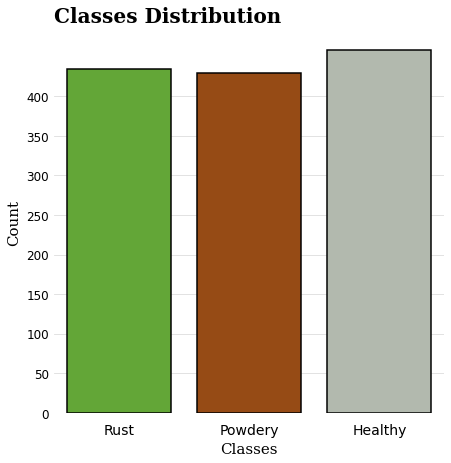

In [ ]:
label_pathes = [os.path.join(config.train_path, label) for label in train_dataset.labels]
label_files = [os.listdir(path) for path in label_pathes]
amount = [len(files) for files in label_files]

palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)
ax.xaxis.set_tick_params(labelsize=14, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_yticks(list(range(0, 450, 50)))
ax.set_title(f"Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
ax.set_ylabel("Count", fontsize=15, fontfamily="serif", labelpad=5)
hide_spines(ax)
fig.show()

In [ ]:
plot_images(rows=5, cols=5, indexes=(0, 25), class_=0)

In [ ]:
plot_images(rows=5, cols=5, indexes=(500, 525), class_=1)

In [ ]:
plot_images(rows=5, cols=5, indexes=(len(train_dataset)-25, len(train_dataset)), class_=2)

In [ ]:
# prepare dataset
train_dataset = PlantDiseaseDataset(path=config.train_path, 
                                    augmentations=train_config.augmentations,
                                    image_shape=train_config.image_shape, 
                                    channels=train_config.image_channels)

validation_dataset = PlantDiseaseDataset(path=config.validation_path, 
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape, 
                                         channels=train_config.image_channels)

test_dataset = PlantDiseaseDataset(path=config.test_path, 
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape, 
                                   channels=train_config.image_channels)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=train_config.batch_size, 
                          num_workers=train_config.num_workers, 
                          pin_memory=True, 
                          shuffle=True, 
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset, 
                               batch_size=train_config.batch_size*2, 
                               num_workers=train_config.num_workers, 
                               pin_memory=True, 
                               shuffle=False, 
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=train_config.batch_size*2, 
                         num_workers=train_config.num_workers, 
                         pin_memory=True, 
                         shuffle=False, 
                         collate_fn=collate_fn)

In [ ]:
# modeling
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes=3):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.ShuffleNetV2([4, 8, 4], [24, 244, 488, 976, 2048],num_classes=classes)      
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [ ]:
class Trainer:
    def __init__(self, model, criterion, optimizer,  metric, scheduler=None, logger=None, device="cpu"):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.logger = logger
        self.device = torch.device(device)
        self.best_validation_loss = 0
        self.metric = metric
        self.history = Dict({})
        
    def __log(self, logs):
        for k, v in logs.items():
            if k not in self.history:
                self.history[k] = []
                
            self.history[k].append(v)
            
    def evaluate(self, loader):
        loss, score, length = 0, 0, len(loader)
            
        self.model.to(self.device)
        with torch.no_grad():
            loop = tqdm(loader, position=0, colour="BLACK", desc=f"Evaluating: ", leave=True)
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.model.eval()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                loss += batch_loss.item()
                
                batch_score = self.metric(predictions, labels).item()
                score += batch_score

            loss /= length
            score /= length
        
        return loss, score
        


    def fit(self, train_loader, validation_loader=None, epochs=10):
        self.model.to(self.device)
        train_length = len(train_loader)
        
        for epoch in range(epochs): 
            epoch_loss, epoch_score = 0, 0
            
            loop = tqdm(train_loader, position=0, colour="BLACK", leave=True, desc=f"Epoch [{epoch+1}/{epochs}]: ")
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                self.model.train()
                
                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()
                
                batch_loss = self.criterion(probabilities, labels)
                epoch_loss += batch_loss.item()
                
                batch_score = self.metric(predictions, labels).item()
                epoch_score += batch_score
                
                batch_loss.backward()
                self.optimizer.step()
                
            epoch_loss /= train_length
            epoch_score /= train_length
            
            self.__log({"train_losses": epoch_loss, "train_scores": epoch_score})
            if self.logger is not None: self.logger.info(f"train Epoch [{epoch+1}/{epochs}]: Loss: {epoch_loss} | Metric: {epoch_score}")
                
            if validation_loader is not None:
                validation_loss, validation_score = self.evaluate(validation_loader)
                self.__log({"validation_losses": validation_loss, "validation_scores": validation_score})
                if self.logger is not None: self.logger.info(f"Validation Epoch [{epoch+1}/{epochs}]: Loss: {validation_loss} | Metric: {validation_score}")
            


                if self.scheduler is not None:
                    if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step(validation_loss)
                    else:
                        self.scheduler.step()

                    if self.logger is not None:
                        lr = self.optimizer.param_groups[0]["lr"]
                        self.logger.info(f"Epoch [{epoch+1}/{epochs}] Learning Rate: {lr}")

3

In [ ]:
model = PlantDiseaseModel(classes=len(train_dataset.labels))
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model=model, 
                          name=train_config.optimizer.type, 
                          parameters=train_config.optimizer.parameters)

if "scheduler" in train_config:
    scheduler = get_scheduler(optimizer=optimizer, 
                              name=train_config.scheduler.type, 
                              parameters=train_config.scheduler.parameters)
    
trainer_logger = get_logger("trainer")
trainer = Trainer(model=model, 
                  criterion=criterion,
                  metric=accuracy_score,
                  optimizer=optimizer, 
                  scheduler=scheduler,
                  logger=trainer_logger,
                  device=train_config.device)

In [ ]:
print(model)

In [ ]:
trainer.fit(train_loader=train_loader, 
            validation_loader=validation_loader, 
            epochs=train_config.epochs)

Epoch [1/5]: 100%|██████████| 21/21 [06:07<00:00, 17.49s/it]
[2023-03-19 10:02:48,505][INFO]: train Epoch [1/5]: Loss: 0.9357146819432577 | Metric: 0.5772037988617307
[2023-03-19 10:02:48,505][INFO]: train Epoch [1/5]: Loss: 0.9357146819432577 | Metric: 0.5772037988617307
[2023-03-19 10:02:48,505][INFO]: train Epoch [1/5]: Loss: 0.9357146819432577 | Metric: 0.5772037988617307
[2023-03-19 10:02:48,505][INFO]: train Epoch [1/5]: Loss: 0.9357146819432577 | Metric: 0.5772037988617307
[2023-03-19 10:02:48,505][INFO]: train Epoch [1/5]: Loss: 0.9357146819432577 | Metric: 0.5772037988617307
Evaluating: 100%|██████████| 1/1 [00:14<00:00, 14.94s/it]
[2023-03-19 10:03:03,470][INFO]: Validation Epoch [1/5]: Loss: 1.2181051969528198 | Metric: 0.3333333432674408
[2023-03-19 10:03:03,470][INFO]: Validation Epoch [1/5]: Loss: 1.2181051969528198 | Metric: 0.3333333432674408
[2023-03-19 10:03:03,470][INFO]: Validation Epoch [1/5]: Loss: 1.2181051969528198 | Metric: 0.3333333432674408
[2023-03-19 10:03:

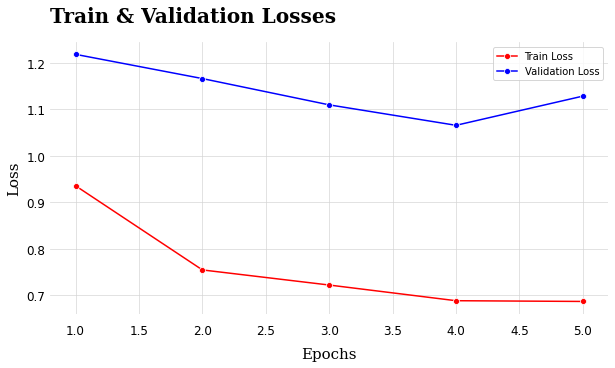

In [ ]:
epochs_ = range(1, train_config.epochs+1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=trainer.history.train_losses, color="red", marker="o", label="Train Loss", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=trainer.history.validation_losses, color="blue", marker="o", label="Validation Loss", zorder=2, ax=ax)
ax.set_title("Train & Validation Losses", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
hide_spines(ax)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Loss", fontsize=15, fontfamily="serif", labelpad=5)
ax.legend()
fig.show()

4th epoch is giving us the maximum accuracy.

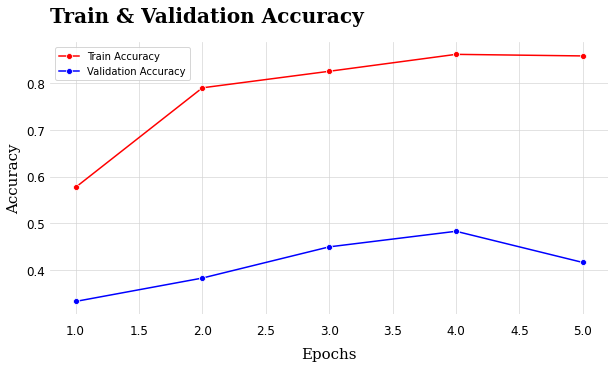

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=trainer.history.train_scores, color="red", marker="o", label="Train Accuracy", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=trainer.history.validation_scores, color="blue", marker="o", label="Validation Accuracy", zorder=2, ax=ax)
ax.set_title("Train & Validation Accuracy", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
hide_spines(ax)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Accuracy", fontsize=15, fontfamily="serif", labelpad=5)
ax.legend()
fig.show()

In [ ]:
trainer.evaluate(test_loader)

Evaluating: 100%|██████████| 2/2 [00:38<00:00, 19.49s/it]


(1.4853121042251587, 0.046164773404598236)